In [143]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import os,sys
from statistics import mean
import numpy as np

In [144]:
current_path = os.path.dirname(os.path.abspath(sys.argv[1]))
TRANSFORM = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(127), transforms.ToTensor()])

train = ImageFolder(current_path + '/animal_pics/training_set', transform = TRANSFORM)
test = ImageFolder(current_path + '/animal_pics/test_set', transform = TRANSFORM)

In [145]:
class CNN(nn.Module):

    def __init__(self, out1 = 8, out2 = 16, out3 = 32, n1 = 64, n2 = 128, n3 = 64):
        super(CNN,self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = out1, kernel_size= 3, stride = 1),
            nn.BatchNorm2d(out1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels = out1, out_channels = out2, kernel_size= 3, stride = 1),
            nn.BatchNorm2d(out2),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels = out2, out_channels = out3, kernel_size= 3, stride = 1),
            nn.BatchNorm2d(out3),
            nn.ReLU(),
            )

        self.fc1 = nn.Sequential(
            nn.Linear(28 * 28 * out3, n1),
            nn.BatchNorm1d(n1),
            nn.ReLU(),

            nn.Linear(n1, n2),
            nn.BatchNorm1d(n2),
            nn.ReLU(),

            nn.Linear(n2, n3),
            nn.ReLU(),

            nn.Linear(n3,2)
        )

    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc1(x)
        return x

In [146]:
def train_model(model, opt, criterion, epochs, train_loader, test_loader):

    stats_dict = {'all_loss':[], 'mean_loss':[], 'accuracy':[], 'models':[]}

    try : 
        for epoch in range(epochs):
        
            print(f'EPOCH {epoch+1}')
            print()
            
            batch_counter = 0
            mean_loss_for_epoch = []

            for x,y in train_loader :

                if batch_counter % 5 == 0 :
                    print(str(batch_counter) + ' --> ', end = '', flush = True)

                model.train()
                opt.zero_grad()

                yhat = model.forward(x)
                loss = criterion(yhat,y)

                stats_dict['all_loss'].append(loss.item())
                mean_loss_for_epoch.append(loss.item())

                loss.backward()
                opt.step()
                batch_counter += 1

            stats_dict['mean_loss'].append(mean(mean_loss_for_epoch))
            stats_dict['models'].append(model)
            print()
            print('Mean loss for epoch :', mean(mean_loss_for_epoch))

            correct = 0
            incorrect = 0
            for x,y in test_loader :

                model.eval()
                yhat = model.forward(x)

                for i in range(len(yhat)) : 
                    if torch.argmax(yhat[i]) == y[i] :
                        correct += 1
                    else :
                        incorrect += 1

            acc = (correct / (incorrect + correct)) * 100
            print('Accuracy on test set : ', acc, '%')
            stats_dict['accuracy'].append(acc)
            print('-' * 50)

        return stats_dict
    except :
        return stats_dict

In [147]:
BATCH_SIZE = 100
EPOCHS = 5
LR = 0.001
MOMENTUM = 0.9

train_loader = DataLoader(dataset = train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test, batch_size = 2000, shuffle = True)

model = CNN()
opt = optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)
loss = nn.CrossEntropyLoss()

stats = train_model(model = model, opt = opt, criterion = loss, epochs = EPOCHS, train_loader = train_loader, test_loader = test_loader)

EPOCH 1

0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 
Mean loss for epoch : 0.6483407363295555
Accuracy on test set :  65.75 %
--------------------------------------------------
EPOCH 2

0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 
Mean loss for epoch : 0.5627834048122168
Accuracy on test set :  71.0 %
--------------------------------------------------
EPOCH 3

0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 
Mean loss for epoch : 0.45038250610232355
Accuracy on test set :  72.1 %
--------------------------------------------------
EPOCH 4

0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 
Mean loss for epoch : 0.3127984456717968
Accuracy on test set :  71.8 %
--------------------------------------------------
EPOCH 5

0 --> 5 --> 10 --

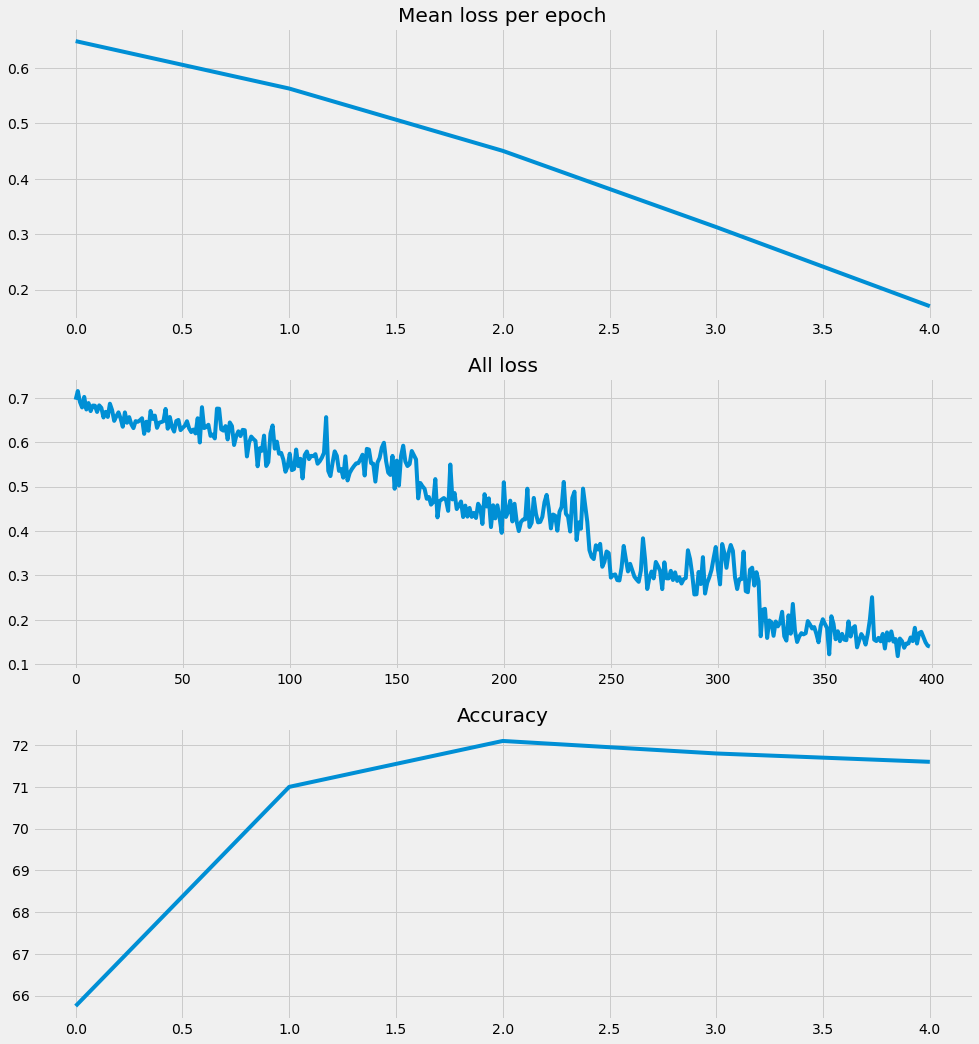

In [157]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15,17))

ax[0].set_title('Mean loss per epoch')
ax[0].plot(stats['mean_loss'])
ax[0].grid(True)

ax[1].set_title('All loss')
ax[1].plot(stats['all_loss'])
ax[1].grid(True)

ax[2].set_title('Accuracy')
ax[2].plot(stats['accuracy'])
ax[2].grid(True)